<a href="https://colab.research.google.com/github/cegildersleeve/Twitter_Airlines_ULMFIT/blob/master/Twitter_Airlines_NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis of Airline Tweets using ULMFIT

##Setting Up

In [1]:
#necessary imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import spacy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime as dt
from datetime import datetime
from sklearn.metrics import fbeta_score,  accuracy_score
import fastai
from fastai import *
from fastai.text import * 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#download datafiles from my git repository
!git clone  https://github.com/cegildersleeve/Twitter_Airlines_ULMFIT

fatal: destination path 'Twitter_Airlines_ULMFIT' already exists and is not an empty directory.


In [0]:
from Twitter_Airlines_ULMFIT import appos


In [0]:
#reading the raw data
tweets = pd.read_csv(r"Twitter_Airlines_ULMFIT/Tweets.csv")

##Initial Exploration

In [5]:
#explore oritinal features of the tweets file
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [6]:
#explore what the data looks like at a glance
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
#convert tweet_created to datetime and make new date values
tweets.tweet_created = pd.to_datetime(tweets.tweet_created)
tweets['weekday'] = tweets.tweet_created.dt.weekday_name
tweets['hour'] = tweets.tweet_created.dt.hour
tweets['month'] = tweets.tweet_created.dt.month_name()

In [0]:
dtypes = tweets.dtypes

In [0]:
#create a list of numerical data types to explore
numerical = dtypes[(tweets.dtypes == 'int64') | (tweets.dtypes == 'float64') ].index.tolist()
numerical.remove('hour')
numerical.remove('tweet_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff94d715f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff94d43a978>]], dtype=object)

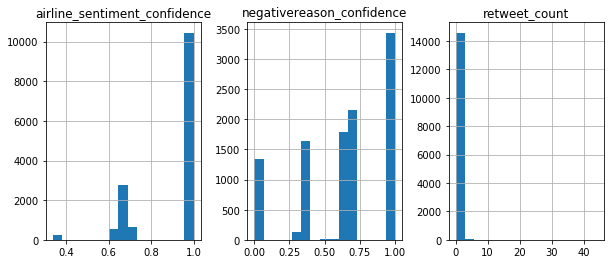

In [10]:
#create histograms for numerical values
tweets[numerical].hist(bins=15, figsize =(10,4), layout=(1,3))

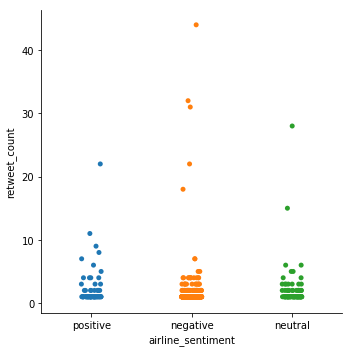

In [11]:
#explore possible differences in retweets
sns.catplot(x="airline_sentiment", y="retweet_count", data=tweets[tweets.retweet_count>0])

In [12]:
#percent of tweets that are retweeted
tweets[tweets.retweet_count>0].shape[0]/tweets.shape[0]

0.05239071038251366

Looking at the numerical data we can see that:

About 5% of tweets are retweeted. The majority of retweet values are 0 or 1
Confidence in a negative reason is high but the central reason in unclear
Sentiment in retweets is skews slightly negative, but there are also more negative tweets as shown later on


In [0]:
#create list of categorical values to explore
categorical = ['airline','weekday','hour','month','airline_sentiment','user_timezone','negativereason']

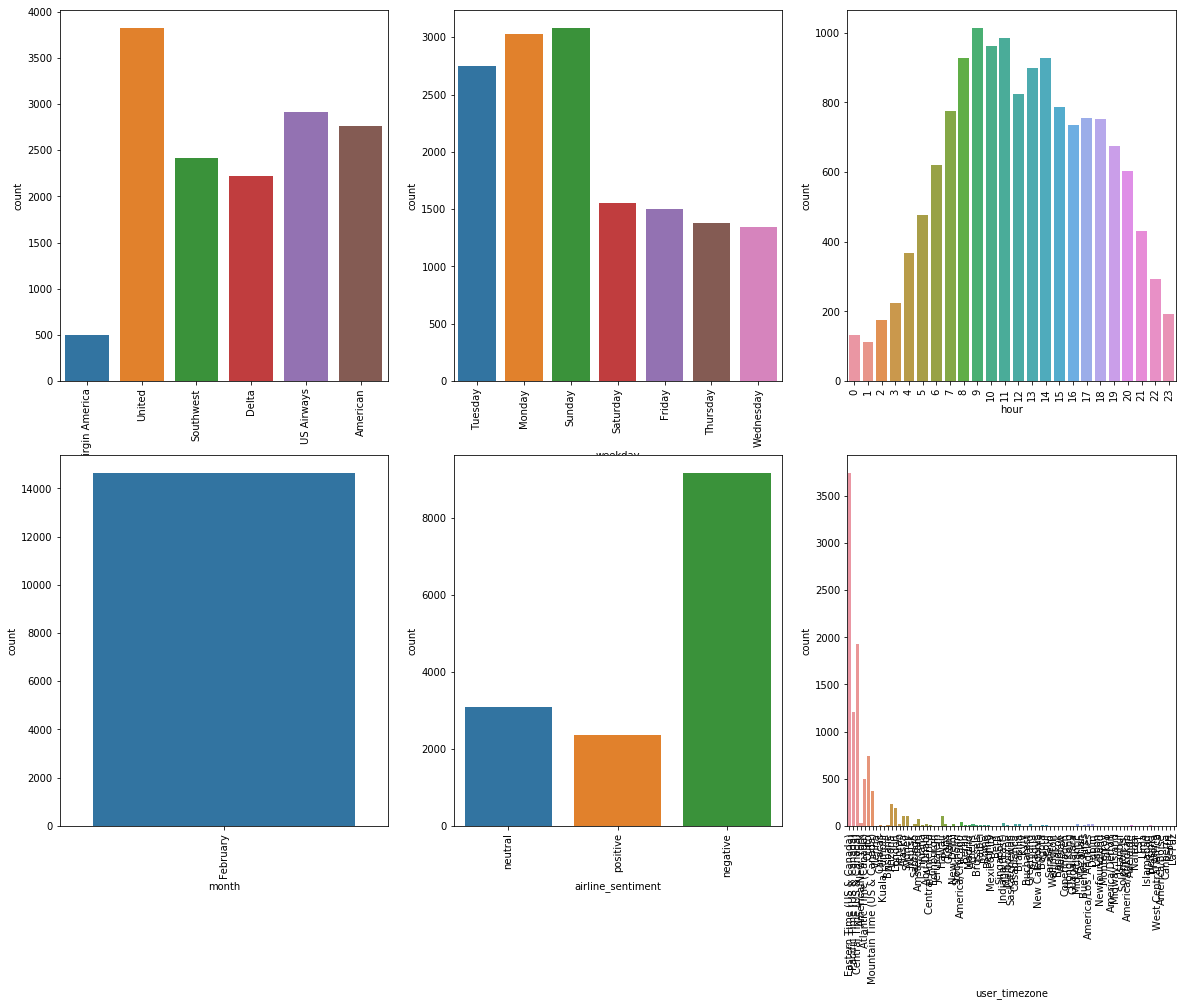

In [14]:
#create count plots for important categorical values
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(tweets[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

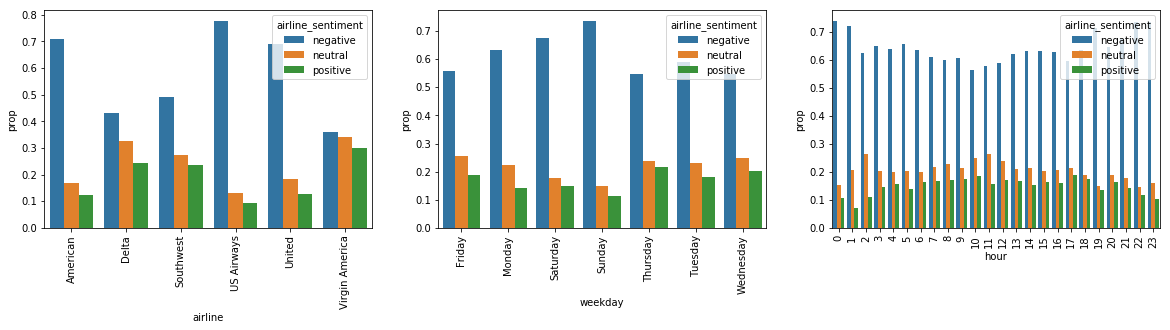

In [15]:
#explore percentages of airline sentiments amongsts specific cateogries
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for variable, subplot in zip(categorical, ax.flatten()):
    prop_df = tweets['airline_sentiment'].groupby(tweets[variable]).value_counts(normalize=True).rename('prop').reset_index()
    sns.barplot(x=variable,y='prop',hue="airline_sentiment", data=prop_df, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Not surprisingly the data has some significant differences across categories. Most notably:

There are significantly more negative tweets than positive or neutral. This may skew predictions to predict more negative.
The number of tweets from the different airlines are disproportionate, and the certain airlines like American, US Airways, and United get more negative tweets.
There is only data from February.

In [16]:
#see what positive tweets look like
tweets[tweets.airline_sentiment=="positive"].text.tolist()[0:5]

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D']

In [17]:
#see what neutral tweets look like
tweets[tweets.airline_sentiment=="neutral"].text.tolist()[0:5]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24',
 '@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?']

Just good to know what the positive and neutral tweets are like, too. Negative tweets were easy to see when calling tweets.head()

#Data Preprocessing

I am using the following tweet pre-processing techniques. 

Remove unicode strings
Replace urls with empty string
Replace user mentions with empty string
Parse out concatenated hashtags with most common words
Replace hashtags with empty string
Replace contractions
Remove numbers
Remove punctuation marks and special characters
Lowercase text
Replace most common misspellings
Replace negations

Given I may want to use these processes again in the future, I am going to create functions for each

In [0]:
def removeUnicode(df_col):
    """ Removes unicode strings like "\u002c" and "x96" """
    df_col = df_col.str.replace(pat=r'(\\u[0-9A-Fa-f]+)',repl=r'')       
    return df_col

def removeURLs(df_col):
    """ Replaces url address with "url" """
    df_col = df_col.str.replace('((www\.[^\s]+)|(https?://[^\s]+))','')
    return df_col

In [0]:
def listHashtags(df_col):
    '''Lists all hashtags from a column of text'''
    hashtags = df_col.str.extractall('#([A-Za-z_]+)')
    hashtags = hashtags.reset_index()
    hashtags = hashtags.drop(columns=['level_0','match'])
    hashtags.columns = ["hashtag"]
    return hashtags.hashtag
    

In [0]:
def parseHashtags(df_col, word_list):
    '''Parses out hashtags by capitol letters and by using a word list'''
    hashtags = df_col.str.extractall('#([A-Za-z_]+)')
    hashtags = hashtags.reset_index()
    hashtags = hashtags.drop(columns=['level_0','match'])
    hashtags.columns = ["hashtag"]
    hashtags['original'] = '#'+hashtags.hashtag
    hashtags.hashtag = hashtags.hashtag.str.replace('((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))', repl=r' \1')
    hashtags.hashtag = hashtags.hashtag.str.lower()
    important_hashtags = word_list
    for x in important_hashtags:
        hashtags.hashtag = hashtags.hashtag.str.replace(x, regex=False, repl=(' ' + x + ' '))
    hashtags.loc[(hashtags.hashtag.str.contains("not", regex=False) == False) | (hashtags.hashtag.str.contains("inno", regex=False) == False) , 'hashtag'] = hashtags.loc[hashtags.hashtag.str.contains("not", regex=False) ==False, 'hashtag'].str.replace('no', regex=False, repl=(' no '))
    hashtags.index = hashtags.original
    hashtag_dict = hashtags.drop(columns='original')
    hashtag_dict = hashtag_dict.to_dict()['hashtag']
    for x in hashtag_dict:
        df_col = tweets.text.str.replace(x, regex=False, repl=str(hashtag_dict[x]).strip())
    return df_col


In [0]:
def removeHandles(df_col):
    '''Removes Twitter handles from text column'''
    df_col = df_col.str.replace('@([A-Za-z_]+)','')
    return df_col
    
    

In [0]:
def splitConcatenatedWords(df_col):
    '''Splits strings where a capitol letter is preceded by a lowercase letter'''
    df_col = df_col.str.replace('((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))', repl=r' \1')
    return df_col

    

In [0]:
def lowercase(df_col):
    '''Converts text column to lowercase'''
    df_col = df_col.str.lower()
    return df_col

In [0]:
def replaceContractions(df_col):
    '''Converts common contractions like 'isn't' to 'is not'''
    for word in appos.appos:
        df_col = df_col.str.replace(word, regex=False, repl=appos.appos[word])
    return df_col

In [0]:
def findMisspellings(df_col, vocab_list, min_freq=5):
    '''returns dataframe with frequencies of most common misspellings descending'''
    count_vector = CountVectorizer(min_df = min_freq)
    count_vector = count_vector.fit(df_col)
    bag_of_words = count_vector.transform(df_col)
    all_words = count_vector.get_feature_names()
    sum_words = pd.DataFrame(bag_of_words.toarray())
    sum_words.columns = all_words
    df_word_freq = pd.DataFrame(sum_words.sum())
    misspelled = [x for x in all_words if x not in vocab_list]
    df_word_freq.columns = ['word']
    df_misspelled = df_word_freq.loc[misspelled,:].sort_values(by='word', ascending = False)
    return df_misspelled

In [0]:
def replaceCommonMisspellings(path_of_csv_lookup_table, df_col):
    '''creates dictionary replacer from csv with columns Word, Count, and Replacement'''
    most_misspelled = pd.read_csv(path_of_csv_lookup_table)
    most_misspelled.index = most_misspelled.Word
    most_misspelled = most_misspelled.drop(columns=['Word','Count'])
    most_misspelled_dict = most_misspelled.to_dict()['Replacement']
    for word in most_misspelled_dict:
        df_col = df_col.str.replace(r'\b'+word+r'\b', repl=(str(most_misspelled_dict[word])))
    return df_col
    


In [0]:
def removeNonAlphabetic(df_col):
    '''Removes characters not in the alphabet'''
    df_col = df_col.str.replace('([^\s\w]|_)+', repl='')
    df_col = df_col.str.replace('([0-9])', repl="")
    return df_col

In [0]:
def lemmatizeText(df_col):
    '''Returns the same text column with all words lemmatized'''
    lemmatized_sentences = []
    for text in tweets.text.tolist():
        doc = nlp(text)
        sentence = " ".join([token.lemma_ for token in doc])
        lemmatized_sentences.append(sentence)
    df_col = lemmatized_sentences
    return df_col

In [0]:
def removeMisspelled(df_col, vocab_list):
    '''Removes all words not found in a vocab list from a column'''
    count_vector = CountVectorizer()
    count_vector = count_vector.fit(tweets.text)
    all_words = count_vector.get_feature_names()
    misspelled = [x for x in all_words if x not in vocab_list]
    for word in misspelled:
        regex = '\b' + word + '\b'
    df_col = df_col.str.replace(regex, '')
    return df_col

In [0]:
def findAntonyms(word):
    '''finds antonymn for word. If antonym is not know, returns 'not word' instead'''
    antonyms = []
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            if lm.antonyms():
                antonyms.append(lm.antonyms()[0].name())
    if len(antonyms) > 0:
        return antonyms
    else:
        return ['not '+word]

In [0]:
def findNegations(sentence):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    sentence = [str(x) for x in (nlp(sentence))]
    i, l = 0, len(sentence)
    negations = []
    negated_words = []
    while i < l:
        word = sentence[i]
        if str(word) == 'not' and i+1 < l:
            negations.append(word+" "+sentence[i+1])
            negated_words.append(sentence[i+1])
        i = i + 1

    return negations, negated_words

In [0]:
def findNegationSubstitutions(sentence):
    '''Finds negations and returns a dictionary with their replacements'''
    negations, negated_words = findNegations(sentence)
    substitute_dict = {}
    i, l = 0, len(negated_words)
    while i < l:
        substitute_dict[negations[i]] = findAntonyms(negated_words[i])[0]
        i = i + 1
    return substitute_dict
        
    

In [0]:
def applySubstitutions(df_col):
    '''Substitutes 'not {word}' with [word]'s antonym if an antonym can be found'''
    df_col_temp = df_col[df_col.str.contains('not', regex=False)]
    for tweet in df_col_temp:
            sub_dict = findNegationSubstitutions(tweet)
            if len(sub_dict) > 0:
                for replacement in sub_dict:
                    tweet = tweet.replace(replacement, sub_dict[replacement])
    return df_col
    

In [0]:
def replaceExactMatch(df_col, match_list):
    '''Replaces words in a text column if an exact match is found'''
    for word in match_list:
        df_col = df_col.str.replace(r'\b'+word+r'\b', repl=(''))
    return df_col

##Let's apply the transformations!

In [0]:
tweets.text = removeUnicode(tweets.text)
tweets.text = removeURLs(tweets.text)

In [36]:
listHashtags(tweets.text)[1:50]

1                      Seductive
2                         stress
3                           fail
4                             VX
5                          noair
6                worstflightever
7                        roasted
8                       SFOtoBOS
9                     sendambien
10                    andchexmix
11                 MoodlitMonday
12    ScienceBehindTheExperience
13                 MoodlitMonday
14                    travelhelp
15                   elevategold
16                       tribute
17                  SoundOfMusic
18                        Oscars
19               guiltypleasures
20               CarrieUnderwood
21                         CMFat
22     neverflyvirginforbusiness
23                      inflight
24               flightattendant
25                     dreampath
26     neverflyvirginforbusiness
27                neverflyvirgin
28                        change
29                  nomorevirgin
30                 uncomfortable
31        

In [0]:
#creates a dictionary of common words I found in the hashtags 
important_hashtags = ['worst', 'sucks','innovative', 'better','lost', 'never', 'thanks','thank', 'best', 'airline', 'time', 
                      'money','home', 'service', 'customer', 'flights','flight', 'fail', 'worse', 'lost', 
                      'delay','happy', 'airline', 'bad', 'bags', 'good','free', 'fun','fly', 'not', 
                      'virginamerica', 'united', 'southwest', 'delta', 'usairways',
                      'american','virgin','usair', 'love','change','nightmare']

In [0]:
#sorts the list by length
important_hashtags.sort(key=len)

In [0]:
tweets.text = parseHashtags(tweets.text, important_hashtags)

In [0]:
tweets.text = removeHandles(tweets.text)

In [0]:
tweets.text = splitConcatenatedWords(tweets.text)

In [0]:
tweets.text = lowercase(tweets.text)

In [0]:
tweets.text = replaceContractions(tweets.text)

In [0]:
tweets.text = removeNonAlphabetic(tweets.text)

In [0]:
#loads spacy using english vocabulary
nlp = spacy.load('en')

In [0]:
#creates a (incomplete) list of english vocabulary
eng_vocab = list(nlp.vocab.strings)

In [0]:
#creates a dataframe with common misspellings. I'd show it but it doesn't work for some reason on Google Colab like it does in Jupyter
misspellings = findMisspellings(tweets.text, eng_vocab)

In [0]:
#Create CSV with common misspellings for classifying
misspellings.to_csv(r"C:\Users\chad.gildersleeve\Documents\common misspellings.csv")

In [0]:
#path of the last file after I fixed misspellings manually
csv_path = r"Twitter_Airlines_ULMFIT/common misspellings v2.csv"

I know there are functions that work by replacing misspelled words by looping through the characters and fixing 1-2 n-grams to see if matches a word in a vocab list. I found these functions to be slow and often innacurate.

In [0]:
tweets.text = replaceCommonMisspellings(csv_path, tweets.text)

In [0]:
tweets.text = applySubstitutions(tweets.text)

In [0]:
tweets.text = lemmatizeText(tweets.text)

Google Collab did not process the same way as Jupyter did, so I am using the file I created in Jupyter.


In [0]:
#Create new processed Twitter file
#tweets.to_csv(r"C:\Users\chad.gildersleeve\Downloads\clean_Tweets.csv"')

##Create Training and Test data sets to prepare for modeling

In [0]:
#read in processed tweets file and prepare columns for fastai
tweets = pd.read_csv(r'Twitter_Airlines_ULMFIT/clean_Tweets.csv')
tweets = tweets.loc[:,['text', 'airline_sentiment']]

tweets.columns = ['text','labels']
tweets = tweets[['labels','text']]

In [0]:
#create test and training df's
df_test = tweets.sample(frac=.2)
df_train = tweets.drop(df_test.index)


In [56]:
#doublecheck both files have roughly the same breakout of labels
df_test.labels.value_counts()/df_test.labels.shape[0]

negative    0.627049
neutral     0.206967
positive    0.165984
Name: labels, dtype: float64

In [57]:
df_train.labels.value_counts()/df_train.labels.shape[0]


negative    0.626878
neutral     0.212859
positive    0.160263
Name: labels, dtype: float64

##Create and Fine-Tune Language Model

In [0]:
#Prepare data for language model
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")

#Prepare data for classifier model
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

#Save prepared data sets
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
#Initiatilize the learn object with the AWD_LSTM language model
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)


In [60]:
#optimizing the last layers with a sightly smaller momentum
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.082728,4.353894,0.244334,00:07


In [61]:
#find tuning the entire model
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.332780,4.092339,0.285422,00:10
1,4.175085,4.008996,0.293527,00:10
2,4.010804,3.967838,0.299880,00:11


I used three epocs to train the language model. After 3 epochs, I noticed that training loss was began to become less than validation loss suggesting overfitting.

In [62]:
#testing out how well the language model predicts the next words of a sentence
learn.predict("American Airlines what a bad bad flight that was give me my", n_words=10)


'American Airlines what a bad bad flight that was give me my kid worse xxbos do -PRON- captain in day xxbos'

In [0]:
#saving the language model
learn.save_encoder('ft_enc')


In [0]:
#creating the classification learn object
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')
learn.freeze()

In [65]:
#showing what the processed data looks like
data_clas.show_batch()


text,target
xxbos i do not have a xxunk count i can not send xxup -pron- mail to xxup -pron- via dm xxup -pron- be not follow xxup -pron- i follow xxup -pron- now so xxup -pron- can xxunk xxup -pron- a dm,neutral
xxbos xxup -pron- stand xxup -pron- up last night but xxup -pron- be give xxup -pron- a second chance xxup -pron- be just a boy tweet an airline ask xxup -pron- to fly xxup -pron- home,negative
xxbos hi just get xxup -pron- tsa precheck amp put xxup -pron- in xxup -pron- acct but xxup -pron- be not on xxup -pron- boarding pass for a flight this pm can xxup -pron- be update,negative
xxbos thank xxup -pron- i leave xxup -pron- i pad on a plane fill out a lost and find form xxup -pron- all find xxup -pron- and ship xxup -pron- back thank xxup -pron- fly sw,positive
xxbos i forgot to put xxup -pron- tsa pre count in before i check in xxup -pron- be now in xxup -pron- profile but will xxup -pron- be on xxup -pron- boarding pass in the am,neutral


In [66]:
#Fit the model
learn.fit_one_cycle(1, 1e-2, moms=(.08,.07))


epoch,train_loss,valid_loss,accuracy,time
0,0.671356,0.546943,0.790642,00:06


In [67]:
#instead of fitting the whole thing, fastai suggests fitting the last few layers first
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3), moms = (.08,.07))

epoch,train_loss,valid_loss,accuracy,time
0,0.614194,0.525279,0.797473,00:08


In [68]:
#again freezing everything but the last few layers
learn.unfreeze()
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3), moms = (.08,.07))

epoch,train_loss,valid_loss,accuracy,time
0,0.573446,0.508227,0.802254,00:12


In [69]:
#fitting the whoe thing now
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.534403,0.516810,0.804986,00:16
1,0.445430,0.501193,0.811817,00:16


#Analyzing the performance

The model has around an 81% accuracy on the test data set. Given the models I viewed not performed on ULMFIT within the kaggle set saw around 70% accuracy, this is fairly strong performance. However, to understand how well the ULFMIT model does, it'd be best to compare it against other models. Below, I start this process by comparing the model to a linear logistic regression model built on a bag of words data set. 

Additionally, no preferences are determined for measuring success. Depending on the solution desired, the model could be adjusted to punish false negatives or false positives more. If this is the case, the model could be transformed to a binary model and optimized on an f-score instead of accuracy. However, given that no preferences are known, I am going to look at the predictions' confusion matrix to help understand each models' overall accuracy..



In [0]:
#getting the predictions, true values, and losses for the validation set
preds,y,losses = learn.get_preds(with_loss=True, ordered=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

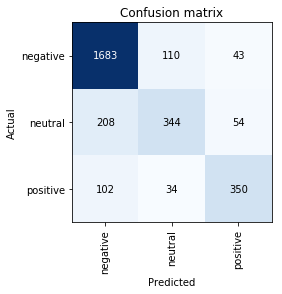

In [71]:
#plotting the confusion matrix
interp.plot_confusion_matrix()


In [0]:
#converting the confusion matrix to percents
confusion_df = pd.DataFrame(interp.confusion_matrix())

confusion_df.columns = ['negative', 'neutral', 'positive']
confusion_df.index = ['negative', 'neutral', 'positive']
for col in confusion_df.columns:
  confusion_df[col] = confusion_df[col]/confusion_df[col].sum()

In [73]:
#plotting the confusion matrix percent accuracies
confusion_df

,negative,neutral,positive
negative,0.844456,0.225410,0.096197
neutral,0.104365,0.704918,0.120805
positive,0.051179,0.069672,0.782998


In [0]:
#prepping the data for a logistic regressino model. first I am replacing the labels with integer values
label_replace = {'positive': 2, 'neutral':1, 'negative':0}
tweets.labels = [label_replace[label] for label in tweets.labels]

In [0]:
# creating a bag of words model for regression
count_vector = CountVectorizer(min_df=3)
count_vector = count_vector.fit(tweets.text)
tweet_array = count_vector.transform(tweets.text).toarray()

bag_of_words = pd.DataFrame(tweet_array, columns = count_vector.get_feature_names())

In [0]:
#splitting the bag of words model into test and training data
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, tweets.labels, test_size = 0.2, random_state = 0)


In [0]:
#initializing the softReg object
softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')


In [78]:
#fitting the softReg model
softReg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#getting predictions
y_test_pred = softReg.predict(x_test)

In [0]:
#creating a confusion matrix with percentages based on results
confusion_matrix_array = confusion_matrix(y_test, y_test_pred)
confusion_df = pd.DataFrame(confusion_matrix_array)

confusion_df.columns = ['negative', 'neutral', 'positive']
confusion_df.index = ['negative', 'neutral', 'positive']
for col in confusion_df.columns:
  confusion_df[col] = confusion_df[col]/confusion_df[col].sum()


In [81]:
#displaying the overall accuracy of the model
accuracy_score(y_test, y_test_pred)

0.7933743169398907

In [82]:
#displaying the softReg's confusion matrix
confusion_df

,negative,neutral,positive
negative,0.855297,0.276339,0.132850
neutral,0.101809,0.626943,0.130435
positive,0.042894,0.096718,0.736715


#Conclusion

Overall, initial comparisons show that the ULMFIT model performs well. It doesn't have a much stronger overall accuracy than the logistic regression model. However, when predicting neutral and positive values, it does a better job producing accuracies that are approximately 11% and 5% better than the logistic regression model.

There is still a lot of work that could be done to improve performance. 

I have not tested how the different features impact performance. Some of the feature engineering techniques could also be tweaked to find the best performing paramaters. For example, we could test :
    frequencing flooring or capping of words.
    additional standardization of words. There were a lot of airport names that could be called 'airport' instead of being read as unknown

We could analyze the which tweets are misclassified to see if there is a pattern that we could solve with a new feature in the feature engineering process.

I also have not explored incorporating discriminative fine-tuning and slanted triangular learning rates. Given, I've seen significant defiation in results when I reran the model through the training process, I may be reaching local mimima. Implementing and testing performance for these two features could signifacantly improve results.

Additionally, we could further explore and optimize other models to see how they perform when classifying the data.